In [1]:
import os
import torch
import pandas as pd
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

# import torchvision.transforms.functional
# import torchvision.transforms.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn

from torchinfo import summary
from tqdm import tqdm

# Planet : Amazon space -- Full model running for multilabel classification

!! This is supposed to become the main jupyternotebook to run the multilabel classification and testing !!

Usefull links:
<https://learnopencv.com/multi-label-image-classification-with-pytorch-image-tagging/>

## 0) Initialization
### 0.1) Getting Module and Functions

In [2]:
from Multi_Model_Amazon_Engine import train_dual, batch_prediction_dual
from Multi_Model_Amazon_Module import AmazonSpaceDual, GroundCNN, CloudCNN, AdjustSaturation

In [3]:
data_folder = '../IPEO_Planet_project'
if not os.path.exists(data_folder):
    data_folder = input("Enter the data folder path: ")
    assert os.path.exists(data_folder), "I did not find the folder at, "+str(data_folder)

## 1) Putting the model on the gpu

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [5]:
ground_model = GroundCNN().to(device)
cloud_model = CloudCNN().to(device)

### + Load previously trained model

In [6]:
if not os.path.exists('ground_model_multilabel_classification.pth'):
    print('Did not find ground pretrained model file')
if not os.path.exists('cloud_model_classification.pth'):
    print('Did not find cloud pretrained model file')
else:
    if device=="cpu":
        ground_model.load_state_dict(torch.load('ground_model_multilabel_classification.pth', map_location=torch.device('cpu')))
        cloud_model.load_state_dict(torch.load('cloud_model_classification.pth', map_location=torch.device('cpu')))
    else:
        ground_model.load_state_dict(torch.load('ground_model_multilabel_classification.pth'))
        cloud_model.load_state_dict(torch.load('cloud_model_classification.pth'))

Did not find ground pretrained model file
Did not find cloud pretrained model file


In [7]:
ground_model.eval()

GroundCNN(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool_avg): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (fc): Linear(in_features=14580, out_features=14, bias=True)
  (batchNorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (loss): BCELoss()
)

In [8]:
cloud_model.eval()

CloudCNN(
  (conv1): Conv2d(3, 10, kernel_size=(10, 10), stride=(1, 1))
  (pool_max): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool_avg): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=13520, out_features=3, bias=True)
  (batchNorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig): Sigmoid()
  (dropped): Dropout(p=0.1, inplace=False)
  (smax): Softmax(dim=1)
)

## 2) Getting the different datasets

In [9]:
train_csv = 'training.csv'
validation_csv = 'validation.csv'
test_csv = 'test.csv'

In [10]:
Transform_choice = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(256),transforms.RandomAutocontrast(p=1), AdjustSaturation(1.2)])

In [11]:
train_dataset = AmazonSpaceDual(csv_file=train_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)
validation_dataset = AmazonSpaceDual(csv_file=validation_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)
test_dataset = AmazonSpaceDual(csv_file=test_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)

## 3) Wrapping into the different dataloaders

In [12]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,drop_last = True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size,drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

## 4) Choice of Criterion and Opitimizer

In [13]:
learning_rate = 0.01

ground_crit = nn.BCEWithLogitsLoss()
cloud_crit = nn.BCELoss()

ground_optim = torch.optim.Adam(ground_model.parameters(), lr=learning_rate)
cloud_optim = torch.optim.Adam(cloud_model.parameters(), lr=learning_rate)

## 5) TRAINING

In [14]:
epochs_number = 2

The_results = train_dual(ground_model,cloud_model, train_dataloader, validation_dataloader, device=device, ground_optimizer= ground_optim, cloud_optimizer=cloud_optim, lr = learning_rate, epochs=epochs_number, ground_loss_fn= ground_crit, cloud_loss_fn=cloud_crit)

Training


1it [00:05,  5.34s/it]

torch.Size([128, 3, 256, 256])
(128, 17) (128, 17)
iter:  0 training:micro f1: 0.371macro f1: 0.104 samples f1: 0.370


21it [00:42,  1.89s/it]

iter: 20 training:micro f1: 1.000macro f1: 0.118 samples f1: 1.000


41it [01:18,  1.76s/it]

iter: 40 training:micro f1: 1.000macro f1: 0.118 samples f1: 1.000


61it [01:54,  1.82s/it]

iter: 60 training:micro f1: 1.000macro f1: 0.118 samples f1: 1.000


81it [02:31,  1.87s/it]

iter: 80 training:micro f1: 0.470macro f1: 0.056 samples f1: 0.461


101it [03:07,  1.82s/it]

iter:100 training:micro f1: 0.333macro f1: 0.059 samples f1: 0.333


121it [03:43,  1.84s/it]

iter:120 training:micro f1: 0.500macro f1: 0.059 samples f1: 0.500


141it [04:20,  1.84s/it]

iter:140 training:micro f1: 0.333macro f1: 0.059 samples f1: 0.333


161it [04:58,  1.86s/it]

iter:160 training:micro f1: 0.724macro f1: 0.163 samples f1: 0.718


181it [05:36,  1.90s/it]

iter:180 training:micro f1: 0.526macro f1: 0.138 samples f1: 0.519


187it [05:47,  1.86s/it]


Validating


62it [01:22,  1.33s/it]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

## 5b) Saving the results into a Json file

In [16]:
import json

# create json object from dictionary
js = json.dumps(The_results)

# open file for writing, "w"
name = f"dual_training_results_{epochs_number}epochs_{batch_size}batchsize_{learning_rate}lr_{ground_crit}_{cloud_crit}_crit_{str(ground_optim).split()[0]} _and_{str(ground_optim).split()[0]}_optim.json"
f = open(name,"a")

# write json object to file
f.write(js)

# close file
f.close()

## 5c) Plotting the training phases metrics

In [ ]:
plt.figure()
plt.plot(np.array(The_results['training']['total_loss']))
plt.title('Training: measured loss evolution')
plt.show()

In [ ]:
plt.figure()
plt.plot(np.array(The_results['training']['macro/f1']))
plt.plot(np.array(The_results['training']['macro/precision']))
plt.plot(np.array(The_results['training']['macro/recall']))
plt.legend(['Average accuracy scores', 'Average precision score', 'Average recall score'])
plt.title('Training: macro average metrics')
plt.show()

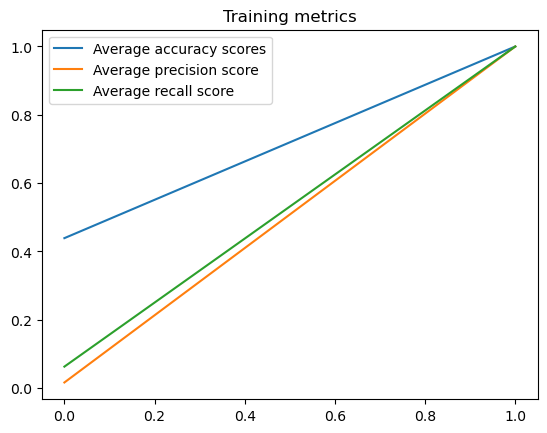

In [17]:
plt.figure()
plt.plot(np.array(The_results['train_acc_scores']).mean(axis=1))
plt.plot(np.array(The_results['train_prec_scores']).mean(axis=1))
plt.plot(np.array(The_results['train_rec_scores']).mean(axis=1))
plt.legend(['Average accuracy scores', 'Average precision score', 'Average recall score'])
plt.title('Training metrics')
plt.show()

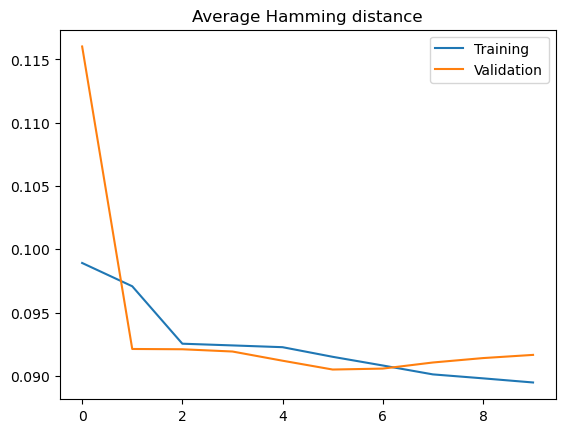

In [41]:
plt.figure()
plt.plot(np.array(The_results['training']['hamming_loss']), label='Training')
plt.plot(np.array(The_results['validation']['hamming_loss']), label='Validation')
plt.legend()
plt.title('Average Hamming distance')
plt.show()

## 6) TESTING

In [42]:
# store stats
losses, accuracies = [], []
count = 0
for batch in tqdm(test_dataloader):
    # TODO run prediction_step
    loss, accuracy, predictions = batch_prediction(batch, model, device = 'cuda')

    # append to stats
    losses.append(loss)
    accuracies.append(accuracy)
    if count == 0:
        all_pred = predictions
        count = 1
    else :
        all_pred = np.vstack((all_pred,predictions))
# average val losses and accuracies over batches
losses, accuracies = np.stack(losses).mean(), np.stack(accuracies).mean()
print(f"valloss {losses:.2f}, val accuracy {accuracies*100:.2f}%")

100%|██████████| 65/65 [02:18<00:00,  2.13s/it]

valloss 0.27, val accuracy 90.25


In [36]:
all_pred

array([[0.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       [0.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       [0.       , 1.       , 1.       , ..., 1.       , 1.       ,
        1.       ],
       ...,
       [0.3828125, 0.8359375, 0.75     , ..., 0.984375 , 0.90625  ,
        0.9375   ],
       [0.3984375, 0.84375  , 0.75     , ..., 0.953125 , 0.859375 ,
        0.9296875],
       [0.3984375, 0.84375  , 0.7265625, ..., 0.9140625, 0.8984375,
        0.8125   ]])

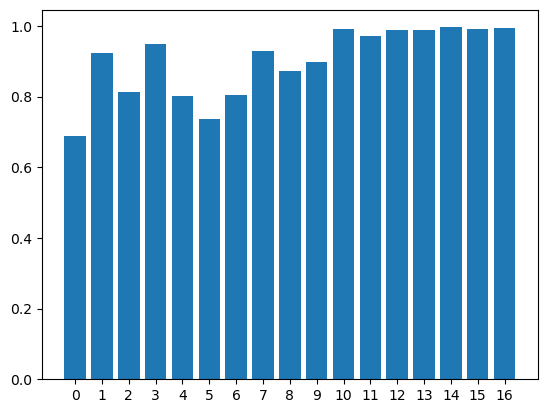

In [45]:
mean_pred = np.stack(all_pred, axis = 0).mean(axis=0)
plt.figure()
plt.bar(x = range(17), height=mean_pred)
plt.xticks(range(17))
plt.title("Accuracy of each class")
plt.show()

# Saving Models

In [46]:
torch.save(model.state_dict(), "model_multilabel_classification.pth")
print("Saved PyTorch Model State to model_multilabel_classification.pth")

Saved PyTorch Model State to model_multilabel_classification.pth
